## Aging DTI 
using SFS / Kmeans and/or XGboost 
5 features !!


In [342]:

from sklearn.cluster import KMeans

import warnings

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.stats as scs

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import xgboost as xgb

import warnings


OPEN FILE SUBJECT IMPUTED AND SFS already computed in other script and saved in SavedFeaturesSelected
 and set parameters

In [344]:

nclust=2
dti_metric='FA'
CC=4

psychophy=0
fonctionalIHD=0
nfeatures=5
list_of_selfeatures=np.load('SavedFeaturesSelectedBackward20to2_CC'+str(CC)+'_'+dti_metric+'.npy',allow_pickle=True)

dataRaw = pd.read_csv('CC_'+str(CC) +'_'+dti_metric+'.csv', sep=",")
SubjectTable_imputed = pd.read_csv('Subject_imputed.csv', sep=",")
#SavedFeaturesSelected=np.load('SavedFeaturesSelected.npy',allow_pickle=True)

#SelectedFeat=SavedFeaturesSelected[0,CC-1]
SelectedFeat=(list_of_selfeatures[nfeatures])
print(SelectedFeat)


Index(['25', '26', '27', '28', '29'], dtype='object')


In [345]:
'CC_'+str(CC) +'_'+dti_metric+'.csv'

'CC_4_FA.csv'

create groups of JND

In [347]:
SubjectTable_imputedNp=SubjectTable_imputed.to_numpy()
JND_Group_only=SubjectTable_imputedNp[:,1]
JNDgroup=[]
for i in JND_Group_only:
     if i>np.median((np.fix(list(JND_Group_only)))):
         JNDgroup.append(0)
     else :
         JNDgroup.append(1)
         
SubjectTable_imputed["JND_group"]=JNDgroup


In [348]:
SubjectTable_imputed.head()

,age,JND_P,IHD,group_O,group_Y,group,JND_group
0,25.0,9.56,0.534027,0.0,1.0,Y,0
1,27.0,6.69,0.570600,0.0,1.0,Y,0
2,28.0,12.92,-0.140120,0.0,1.0,Y,0
3,21.0,1.95,0.488581,0.0,1.0,Y,1
4,25.0,2.54,0.578001,0.0,1.0,Y,1


Keep only selectef feat in a new table called data
extract group (Y and old)
will serve as predictor (target var for Shap for example)

In [350]:


data=pd.concat([dataRaw.loc[:,SelectedFeat], SubjectTable_imputed], axis=1)
Y_group=data["group"] 
Y_JND=data["JND_group"] 
dataready=data.drop(['age','group_Y', 'group_O', 'JND_group', 'group'], axis=1)
dataready.head()
dataready.columns

Index(['25', '26', '27', '28', '29', 'JND_P', 'IHD'], dtype='object')

Corr Matrix

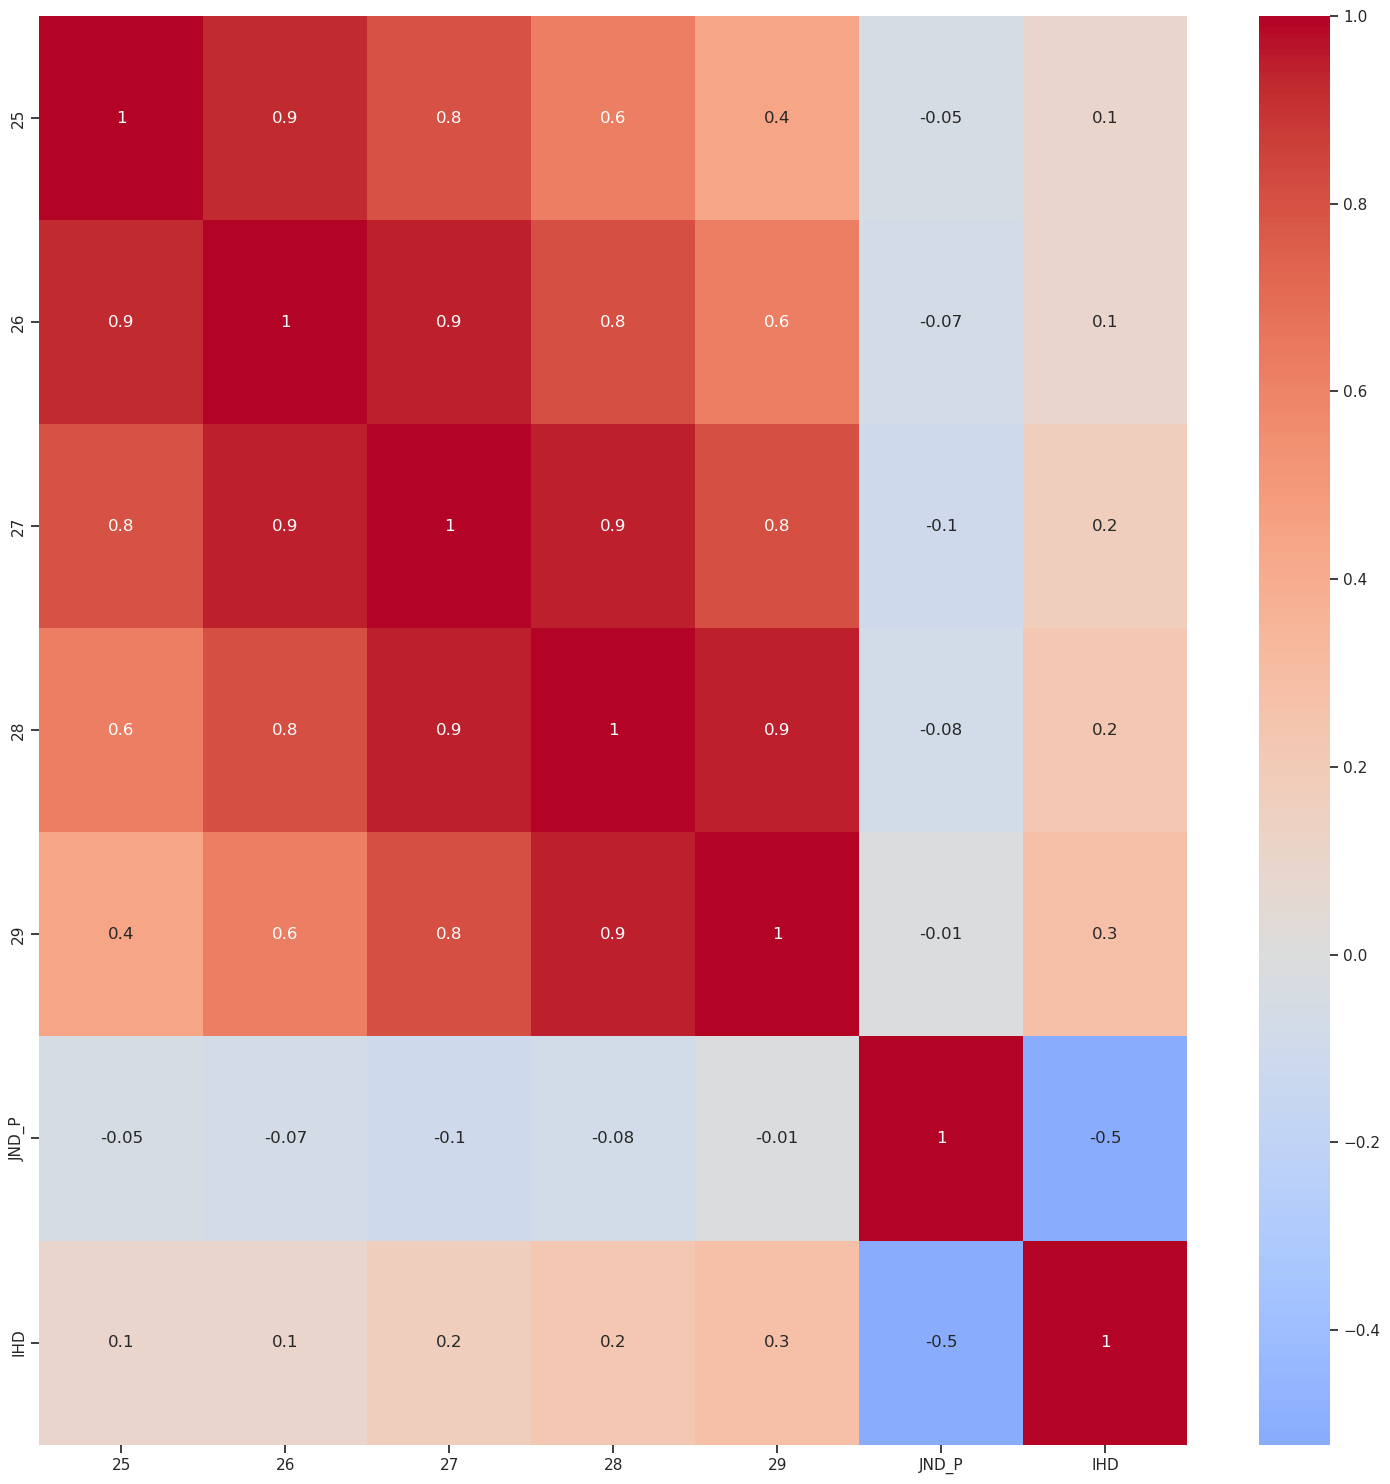

In [353]:

cont=dataready.columns
corr_matrix=pd.DataFrame(dataready[cont],columns=cont).corr()

fig, axes = plt.subplots(1, 1, figsize=(15, 15))#, sharey=True)

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.1g')
plt.tight_layout()

SCALING

In [355]:
X_df=dataready 

if psychophy==0:
    X_df=X_df.drop(['JND_P',], axis=1)
if fonctionalIHD==0:
    X_df=X_df.drop(['IHD',], axis=1)
    
X_df.head()



,25,26,27,28,29
0,0.366919,0.382942,0.386189,0.393351,0.391979
1,0.334236,0.332336,0.321369,0.310518,0.312485
2,0.434809,0.436301,0.424604,0.395501,0.364252
3,0.364604,0.362750,0.368268,0.375700,0.384900
4,0.403722,0.411168,0.424524,0.442797,0.456575


## Scaling and KMEANS

testing quality of clustering 

In [357]:
#SCALING 
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X_df)
Xscaled_df = pd.DataFrame(Xscaled, columns=X_df.columns)
Xscaled_df.head()

,25,26,27,28,29
0,-0.643139,-0.027919,0.142923,0.342203,0.290274
1,-1.589930,-1.521073,-1.555892,-1.501173,-1.245403
2,1.323503,1.546485,1.149718,0.390052,-0.245356
3,-0.710218,-0.623681,-0.326750,-0.050615,0.153526
4,0.422969,0.804898,1.147616,1.442568,1.538145


In [358]:
#KMEANS  
kmeans = KMeans(n_clusters=nclust, random_state=42).fit(Xscaled_df)
kmeans.labels_
CenterCluster=kmeans.cluster_centers_
labels_CC = kmeans.labels_
print(str(nclust)+' clusters')
print(CenterCluster)
print(labels_CC)

2 clusters
[[ 0.69169212  0.81943297  0.86350502  0.84185237  0.74428154]
 [-0.72809697 -0.86256102 -0.90895265 -0.88616039 -0.78345425]]
[0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0
 1 0]


In [359]:
#AllSilScore,AllCalHar,Allinertia=[],[],[]

SilScore=[]
CalHar=[]
DavBouldin=[]
inertia=[]
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(Xscaled_df)
    SilScore.append(silhouette_score(Xscaled_df, kmeans.fit_predict(Xscaled_df)))
    CalHar.append(calinski_harabasz_score(Xscaled_df, kmeans.labels_))
    # DavBouldin.append(davies_bouldin_score(X, labels))
    inertia.append(kmeans.inertia_)  # Inertie (cohésion)

#AllSilScore.append(SilScore)
#AllCalHar.append(CalHar)
#Allinertia.append(inertia)



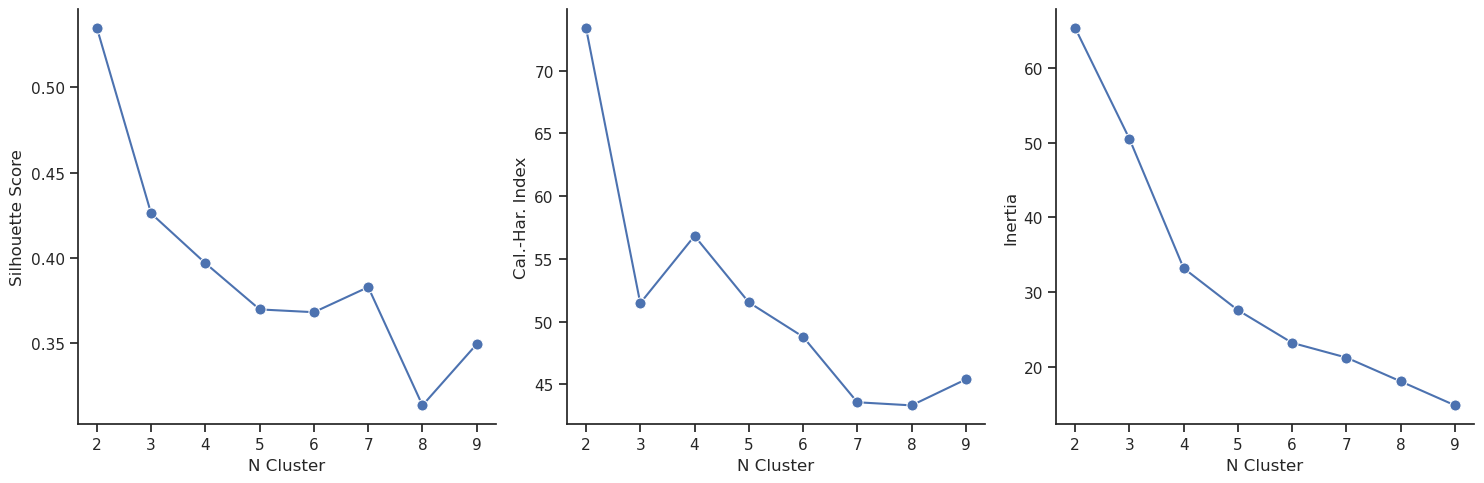

In [360]:
K_range = range(2, 10)  
    
df = pd.DataFrame({'Silhouette Score': SilScore,'Inertia': inertia,
               'Cal.-Har. Index': CalHar,'N Cluster': K_range})
df.head
sns.set_theme(style="ticks")



fig, axes = plt.subplots(1, 3, figsize=(15, 5))#, sharey=True)

sns.lineplot(ax=axes[0],data=df, y='Silhouette Score', x='N Cluster', marker='o',markersize=8)
sns.lineplot(ax=axes[1],data=df, x='N Cluster', y='Cal.-Har. Index', marker='o',markersize=8)
sns.lineplot(ax=axes[2],data=df, x='N Cluster', y='Inertia', marker='o',markersize=8)
axes[0].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
axes[2].spines[['right', 'top']].set_visible(False)
plt.tight_layout()

In [361]:
SelectedFeat

Index(['25', '26', '27', '28', '29'], dtype='object')

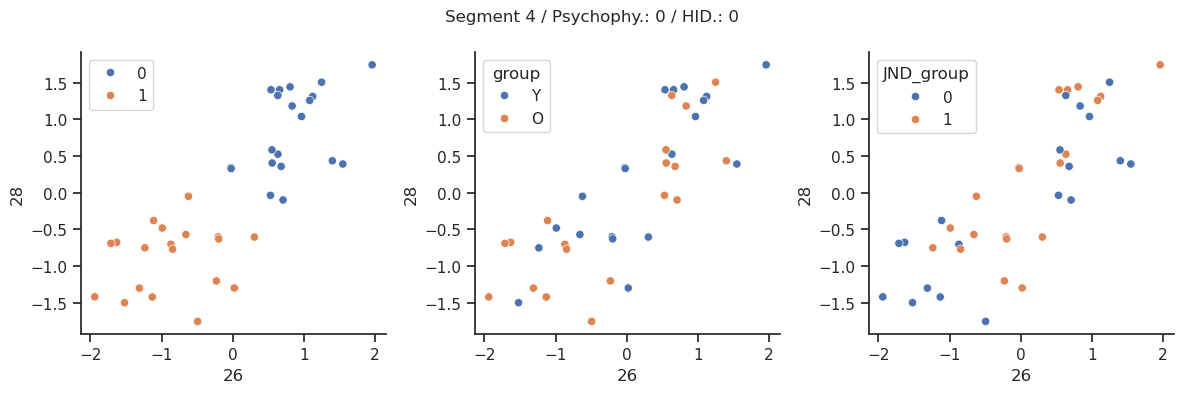

In [362]:
f1=SelectedFeat[1]
f2=SelectedFeat[3]


fig, axes = plt.subplots(1, 3, figsize=(12, 4))#, sharey=True)
fig.suptitle('Segment ' + str(CC)  + ' / Psychophy.: ' + str(psychophy) + ' / HID.: ' + str(fonctionalIHD), fontsize=12 )# or plt.suptitle('Main title')    
t=sns.scatterplot(ax=axes[1],data=Xscaled_df, x=f1, y=f2,hue=SubjectTable_imputed["group"]) 

sns.scatterplot(ax=axes[0],data=Xscaled_df, x=f1, y=f2,hue=labels_CC) 
sns.scatterplot(ax=axes[2],data=Xscaled_df, x=f1, y=f2,hue=SubjectTable_imputed["JND_group"]) 

axes[1].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
axes[0].spines[['right', 'top']].set_visible(False)
axes[0].spines[['right', 'top']].set_visible(False)
axes[2].spines[['right', 'top']].set_visible(False)
axes[2].spines[['right', 'top']].set_visible(False)
plt.tight_layout()

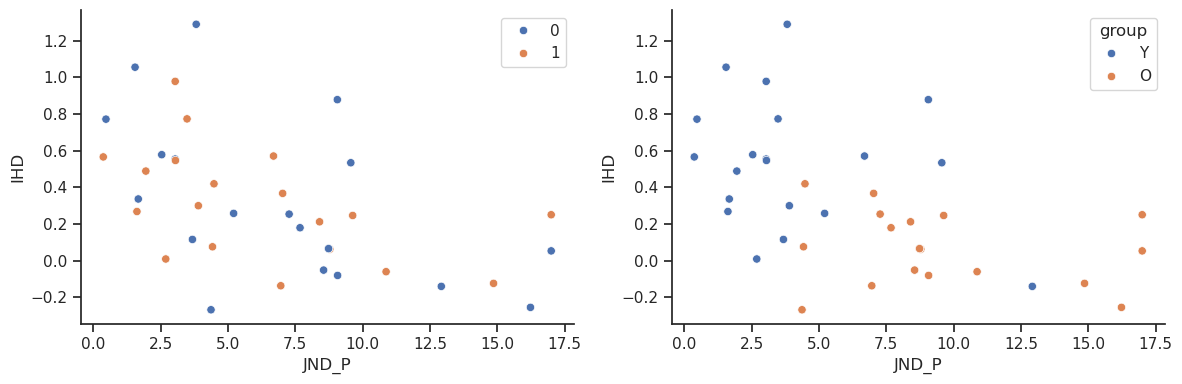

In [363]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))#, sharey=True)

sns.scatterplot(ax=axes[0],data=Xscaled_df, x=SubjectTable_imputed["JND_P"], y=SubjectTable_imputed["IHD"],hue=labels_CC) 
axes[0].spines[['right', 'top']].set_visible(False)
axes[0].spines[['right', 'top']].set_visible(False)

sns.scatterplot(ax=axes[1],data=Xscaled_df, x=SubjectTable_imputed["JND_P"], y=SubjectTable_imputed["IHD"],hue=SubjectTable_imputed["group"]) 
axes[1].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
plt.tight_layout()

In [364]:
import seaborn as sns

sns.set_theme(style="ticks")

SubjectTable_imputed["group"]
data.head()

,25,26,27,28,29,age,JND_P,IHD,group_O,group_Y,group,JND_group
0,0.366919,0.382942,0.386189,0.393351,0.391979,25.0,9.56,0.534027,0.0,1.0,Y,0
1,0.334236,0.332336,0.321369,0.310518,0.312485,27.0,6.69,0.570600,0.0,1.0,Y,0
2,0.434809,0.436301,0.424604,0.395501,0.364252,28.0,12.92,-0.140120,0.0,1.0,Y,0
3,0.364604,0.362750,0.368268,0.375700,0.384900,21.0,1.95,0.488581,0.0,1.0,Y,1
4,0.403722,0.411168,0.424524,0.442797,0.456575,25.0,2.54,0.578001,0.0,1.0,Y,1


/home/nicolascatz/anaconda3/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'truncate'
  cset = contour_func(
/home/nicolascatz/anaconda3/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'truncate'
  cset = contour_func(


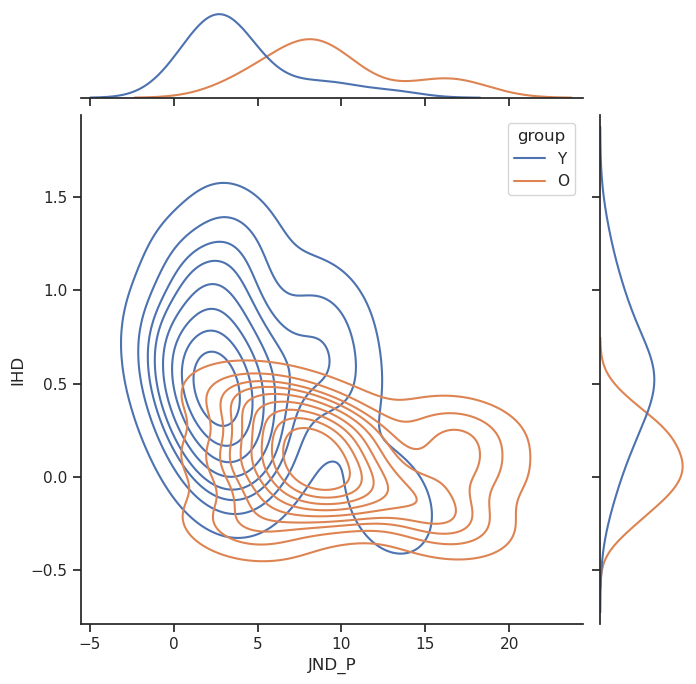

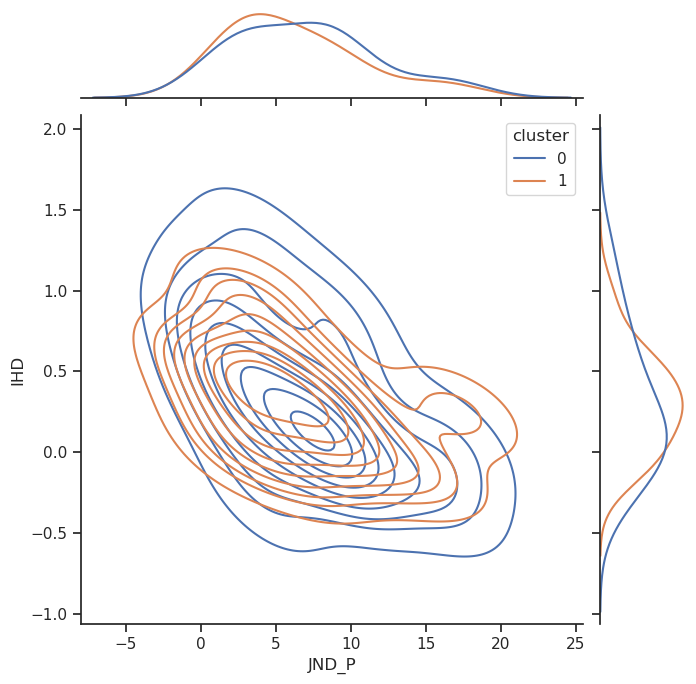

In [365]:

SubjectTable_imputed["cluster"]=labels_CC
g = sns.jointplot(x="JND_P", y="IHD", data=SubjectTable_imputed, kind="kde",hue="group", truncate=False,color="m", height=7)
g = sns.jointplot(x="JND_P", y="IHD", data=SubjectTable_imputed, kind="kde",hue="cluster", truncate=False,color="m", height=7)


### **Plot prediction of Age Groupe and JND from clusters**

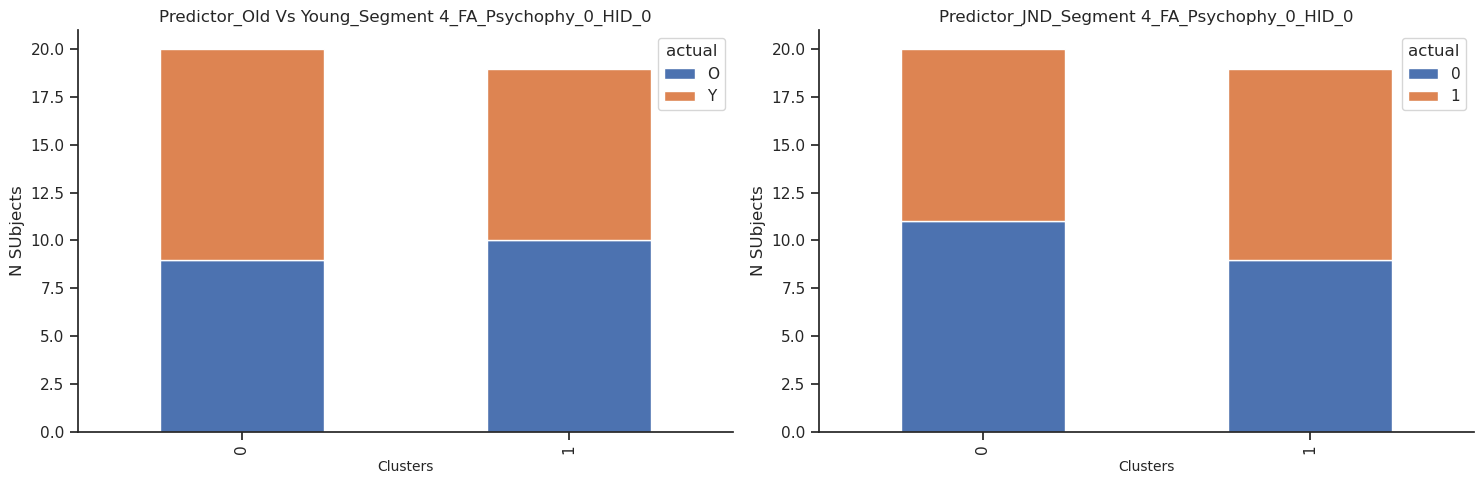

In [367]:

if psychophy==1:
    predicteur_list=['Old Vs Young']
else :
    predicteur_list=['Old Vs Young','JND']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))#, sharey=True)

for predicteurID in range(len(predicteur_list)):
    
    predicteur_str=predicteur_list[predicteurID]
    
    if predicteur_str=='JND':
            predicteur=JNDgroup
    elif predicteur_str=='Old Vs Young':
            predicteur=SubjectTable_imputed["group"]

    if predicteurID==0:
        a=0
    elif predicteurID==1:
        a =1

    df_clusters = pd.DataFrame({
    'actual': predicteur, 
    'predicted': labels_CC   
    })
     
    df_clusters = df_clusters.sort_values(by='predicted')
    
    group_distribution = pd.crosstab(df_clusters['predicted'], df_clusters['actual'])
     
    group_distribution.plot(ax=axes[a],kind='bar', stacked=True)
    
    axes[a].set_xlabel("Clusters", fontsize=10)
    axes[a].set_ylabel("N SUbjects", fontsize=12)
    axes[a].set_title('Predictor_' + predicteur_str+ '_Segment ' + str(CC)  + '_' + dti_metric + '_Psychophy_'
                   + str(psychophy) + '_HID_' + str(fonctionalIHD), fontsize=12)
    axes[a].spines['top'].set_visible(False)
    axes[a].spines['right'].set_visible(False)

   
plt.tight_layout()
    

#plt.savefig('Segment_' + str(CC) + '_' + dti_metric  + '_ Psychophy_' + str(psychophy) + '_ HID_' + 
#            str(fonctionalIHD)+'.eps', format='eps', bbox_inches="tight")

plt.show()

In [368]:
df_clusters.head()
X=X_df

now that we have identify that X clusters based on best features were detected and good predictor of group and JNP, let's train a **DecisionTree** supervised to verify

In order to find the best parameter to the model, **to avoid overfitting I used a 2 different GridSearchCV**


### **HalvingGridSearchCV**

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'splitter': 'random'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



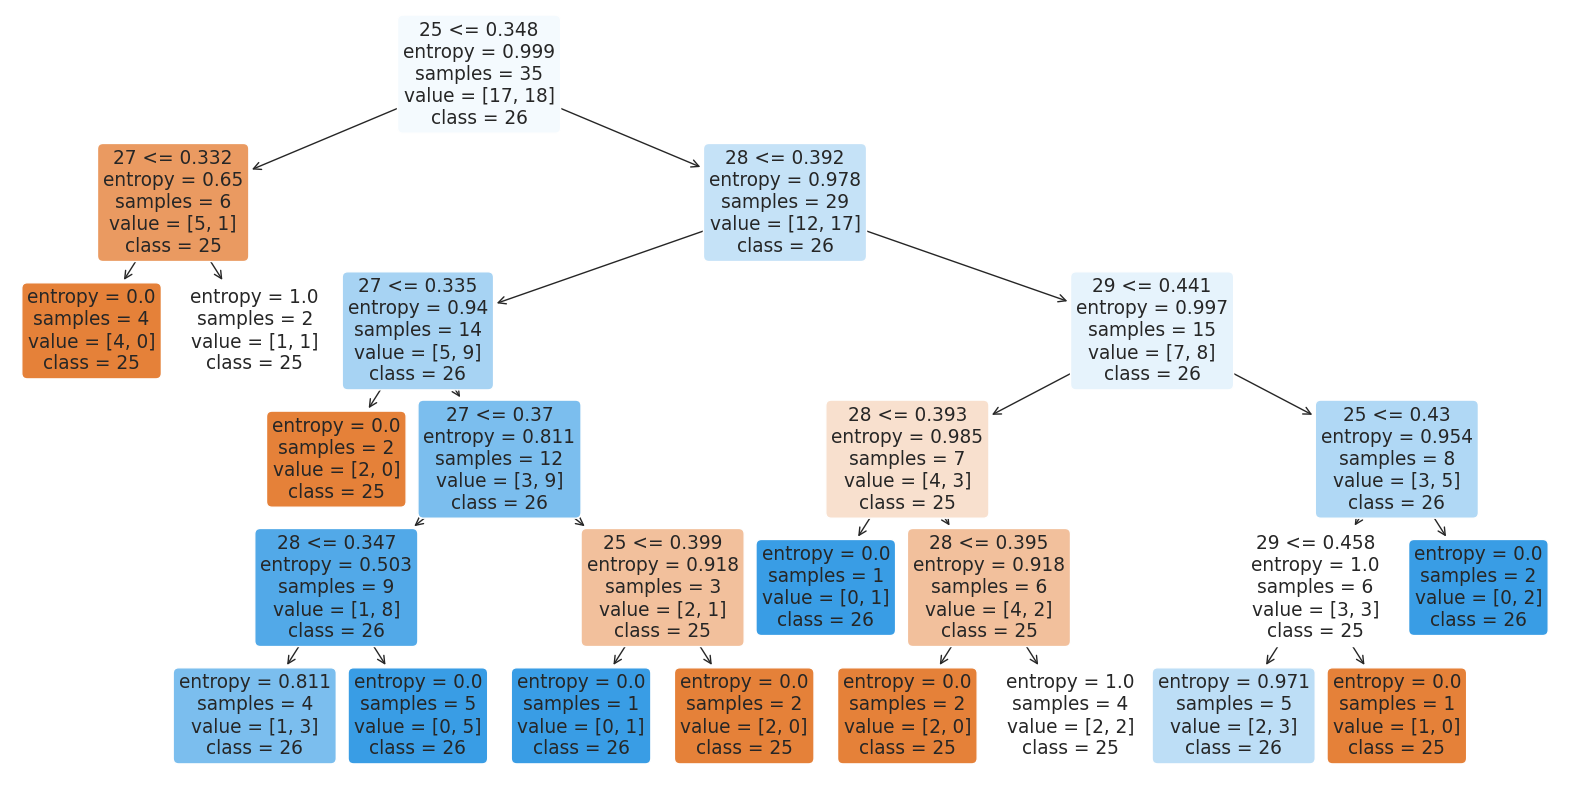

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=3,
                       random_state=42, splitter='random')

In [371]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, roc_auc_score)
from sklearn import tree
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

X=X_df
X_df.head()

# Load the iris dataset as an example
Y_group=data["group"] 
Y_JND=data["JND_group"]
#Y_Cluster=labels_CC
y=Y_JND

Xscaled_df.head()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

param_grid = {'max_depth': [2,3,4 ,5, None],'splitter': ['best', 'random'],'criterion': ['gini', 'entropy'],"min_samples_split": [3,4,5]}

# Initialize the DecisionTreeClassifier and GridSearchCV
tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = HalvingGridSearchCV(tree_clf, param_grid,random_state=42,factor=3, cv=5).fit(X_train, y_train)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate the best estimator on the test data
y_pred = best_estimator.predict(X_test)




print(classification_report(y_test, y_pred))


import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


# Plot the best decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_estimator, filled=True, feature_names=X_df.columns, class_names=X_df.columns, rounded=True)
plt.show()
best_estimator


Confusion Matrix:
[[3 0]
 [0 1]]


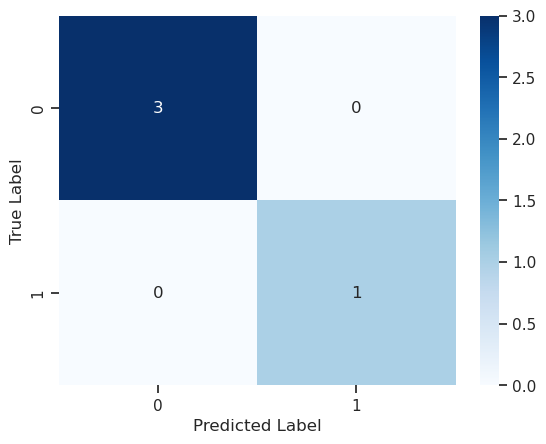

In [372]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualizing the Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [373]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [374]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_estimator, X, y, cv=5)
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")

Cross-Validation Accuracy Scores: [0.5        0.75       0.875      0.375      0.28571429]
Mean CV Accuracy: 0.5571


### **DECISION TREE SHAP REGRESSOR**
